In [1]:
import re
import numpy as np
from collections import Counter
import string
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import h5py
import pickle 
from keras.models import load_model
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import os
import metrics
import helper_functions as hf

np.seterr(all='ignore');

Using TensorFlow backend.


In [2]:
max_len = 50
max_vocab = 5000 #10000
num_datafiles = -1
EMBEDDING_DIM = 128 
DROPOUT_RATE = 0.2
epochs = 2
batch_size = 16

In [3]:
path_to_files = 'corpera/europarl_raw/danish/'
all_files = [files for (path, dirs, files) in os.walk(path_to_files)][0]
all_sentences = []
for file in all_files[:num_datafiles]:
    if file.endswith(".da"):
        with open(path_to_files + file) as f:
            sentences = f.readlines()
            for sentence in sentences:
                all_sentences.append(sentence)
                
print(len(all_sentences))

1501662


In [4]:
cleaned_sentences = [hf.remove_space_before_comma_and_period(sentence) for sentence in all_sentences]
vocabulary, reverse_vocabulary = hf.define_vocabulary(cleaned_sentences, max_vocab)

In [5]:
X, Y = hf.pre_process(all_sentences, max_len, vocabulary)

# Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.005, random_state=42)

In [7]:
def build_model(PARAMETERS):
    model = Sequential()
    model.add(Embedding(len(vocabulary)+2,
                        EMBEDDING_DIM,
                        input_length=max_len))
    model.add(Dropout(PARAMETERS['DROPOUT']))
    model.add(Conv1D(filters=64,
                     kernel_size=5,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(50))
    model.add(Dense(max_len))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [8]:
def sample_hyper_parameter_space():
    DROPOUT =  np.random.rand()
    LEARNING_RATE = 10**(-np.random.randint(1,5))
    BATCH_SIZE = 2**np.random.randint(3,11)
    EMBED_DIM = 2**np.random.randint(3,8)
    EPOCHS = 2
    PARAMETERS = {}
    PARAMETERS['DROPOUT'] =  DROPOUT
    PARAMETERS['LEARNING_RATE'] = LEARNING_RATE
    PARAMETERS['BATCH_SIZE'] = BATCH_SIZE
    PARAMETERS['EMBED_DIM'] = EMBED_DIM
    PARAMETERS['EPOCHS'] = EPOCHS
    return PARAMETERS

In [9]:
PARAMETERS = sample_hyper_parameter_space()
print(PARAMETERS)

{'DROPOUT': 0.37567479564767214, 'LEARNING_RATE': 0.1, 'BATCH_SIZE': 1024, 'EMBED_DIM': 128, 'EPOCHS': 2}


In [10]:
model = build_model(PARAMETERS)

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 128)           640256    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 64)            41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
Total para

In [12]:
RUNS = []
for i in range(4):
    PARAMETERS = sample_hyper_parameter_space()
    print(PARAMETERS)
    model = build_model(PARAMETERS)
    METRIC_CALLBACK = metrics.callback()
    HISTORY = model.fit(X_train, y_train,
              batch_size=PARAMETERS['BATCH_SIZE'],
              epochs=PARAMETERS['EPOCHS'],
              verbose=1,
              validation_data=(X_test, y_test),
              callbacks=[METRIC_CALLBACK])
    RUNS.append([PARAMETERS, HISTORY, METRIC_CALLBACK])
    #model.save('model.h5')

{'DROPOUT': 0.17381966272557559, 'LEARNING_RATE': 0.01, 'BATCH_SIZE': 32, 'EMBED_DIM': 8, 'EPOCHS': 2}
Train on 1494153 samples, validate on 7509 samples
Epoch 1/2
1494153/1494153 [==============================] - 2141s - loss: 0.0573 - acc: 0.9821 - val_loss: 0.0354 - val_acc: 0.9895
Epoch 2/2
1494153/1494153 [==============================] - 2143s - loss: 0.0345 - acc: 0.9896 - val_loss: 0.0306 - val_acc: 0.9909
{'DROPOUT': 0.006939182160825896, 'LEARNING_RATE': 0.1, 'BATCH_SIZE': 512, 'EMBED_DIM': 16, 'EPOCHS': 2}
Train on 1494153 samples, validate on 7509 samples
Epoch 1/2
1494153/1494153 [==============================] - 659s - loss: 0.1028 - acc: 0.9691 - val_loss: 0.0712 - val_acc: 0.9772
Epoch 2/2
1494153/1494153 [==============================] - 659s - loss: 0.0607 - acc: 0.9801 - val_loss: 0.0507 - val_acc: 0.9833
{'DROPOUT': 0.07393974822786442, 'LEARNING_RATE': 0.01, 'BATCH_SIZE': 256, 'EMBED_DIM': 128, 'EPOCHS': 2}
Train on 1494153 samples, validate on 7509 samples
Epo

In [13]:
RUNS

[[{'BATCH_SIZE': 32,
   'DROPOUT': 0.17381966272557559,
   'EMBED_DIM': 8,
   'EPOCHS': 2,
   'LEARNING_RATE': 0.01},
 [{'BATCH_SIZE': 512,
   'DROPOUT': 0.006939182160825896,
   'EMBED_DIM': 16,
   'EPOCHS': 2,
   'LEARNING_RATE': 0.1},
 [{'BATCH_SIZE': 256,
   'DROPOUT': 0.07393974822786442,
   'EMBED_DIM': 128,
   'EPOCHS': 2,
   'LEARNING_RATE': 0.01},
 [{'BATCH_SIZE': 32,
   'DROPOUT': 0.5952339918385822,
   'EMBED_DIM': 128,
   'EPOCHS': 2,
   'LEARNING_RATE': 0.01},

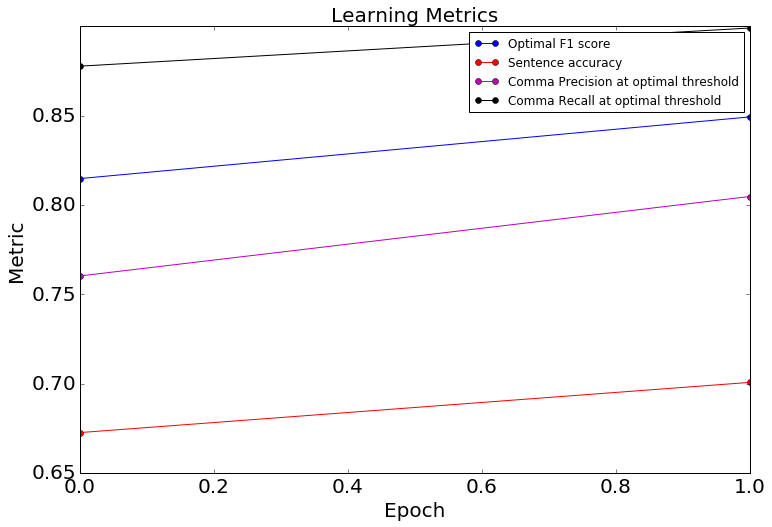

In [14]:
metrics.plot_metrics(METRIC_CALLBACK)

In [15]:
#model = load_model('model.h5')

Final training loss   0.0402415307149
Final validation loss 0.0330621972712


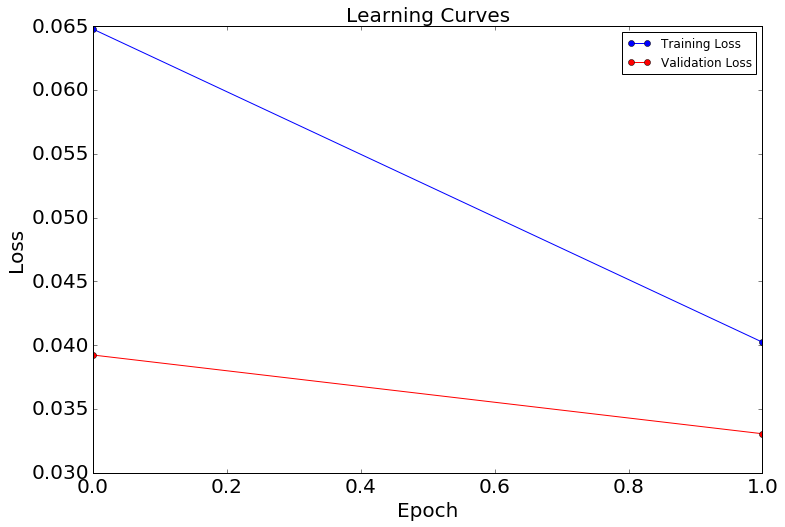

In [16]:
metrics.plot_learning_curves(HISTORY)

In [17]:
y_hat = model.predict_proba(X_test)

7360/7509 [============================>.] - ETA: 0s

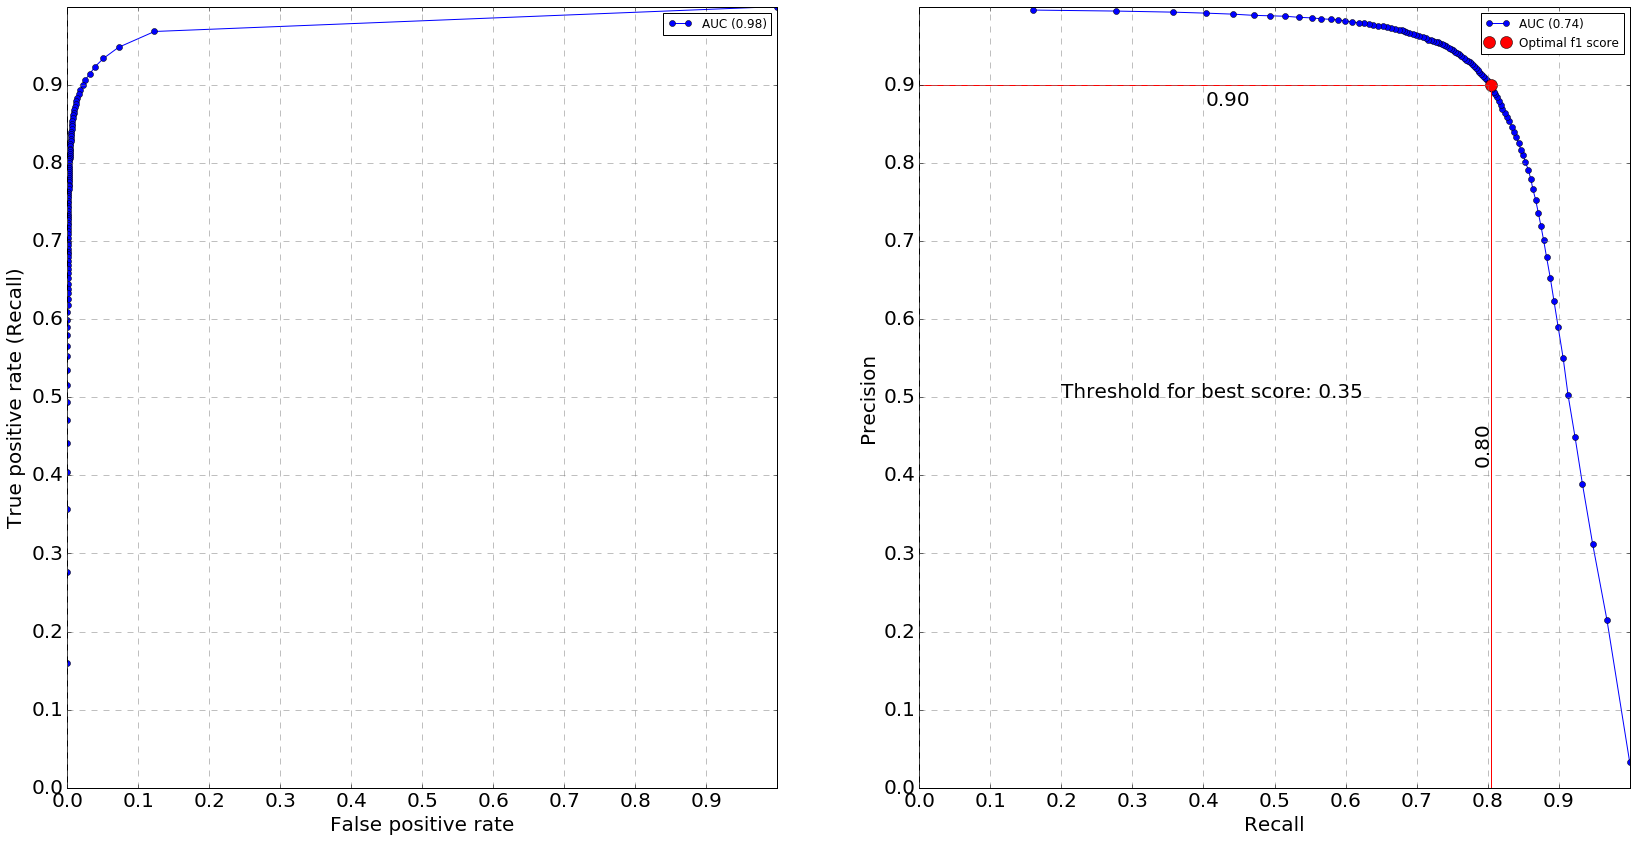

In [18]:
metrics.make_roc_pr_plot(y_test, y_hat)

# Get the optimal threshold by doing f1 analysis

In [19]:
precision, recall, _ = metrics.pr_analysis(y_test, y_hat)

In [20]:
thresholds = np.arange(0,1,0.01)

In [21]:
best_threshold, best_f1, precision_at_threshold, recall_at_threshold = metrics.get_optimal_threshold(precision, recall, thresholds)

In [22]:
print('Threshold: {:0}, precision: {:1.2f}, recall: {:2.2f}'.format(best_threshold[0],
                                                              precision_at_threshold[0],
                                                              recall_at_threshold[0]))

Threshold: 0.35000000000000003, precision: 0.90, recall: 0.80


# Sentence accuracy

In [23]:
sentence_accuracy = metrics.get_sentence_accuracy(y_test, y_hat, best_threshold)
sentence_accuracy

0.70062591556798504

# Write function that gets a fp or fn from the test set

In [24]:
reverse_vocabulary[0] = ''
reverse_vocabulary[1] = 'UNKNOWN'

In [25]:
idx = 29
hf.reverse_embedding(X_test[idx], y_test[idx], reverse_vocabulary, y_hat[idx], threshold=0.4)

Men det afhænger naturligvis også i høj grad af, [tp] hvordan sidste års budget for landbrugspolitikken ser ud, [tp] og hvordan den videre udvikling af mund- og UNKNOWN kommer til at se ud .                  


# Write function that takes arbirary string as input

In [26]:
all_sentences[1]

'Godkendelse af protokollen fra foregående møde Protokollen fra mødet i går er omdelt .\n'

In [28]:
text = 'Hvis man gentager et ord mange mange gange så burde man indføre et komma og desuden skal sætninger afsluttet med et punktum'
hf.make_prediction_from_raw(text, vocabulary, reverse_vocabulary, max_len, model, 0.1)

Raw input:
Hvis man gentager et ord mange mange gange så burde man indføre et komma og desuden skal sætninger afsluttet med et punktum
EU formatting:
Hvis man gentager et ord mange mange gange så burde man indføre et komma og desuden skal sætninger afsluttet med et punktum
remove space before comma:
Hvis man gentager et ord mange mange gange så burde man indføre et komma og desuden skal sætninger afsluttet med et punktum
y is: (we dont use this now, but will perhaps later.)
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Remove commas before embedding:
Hvis man gentager et ord mange mange gange så burde man indføre et komma og desuden skal sætninger afsluttet med et punktum
Unknown words: ['komma', 'sætninger', 'punktum']
After embedding:
[[ 160   44 2199   22  519   96   96  585   38  433   44  605   22    1
     4  758   27   

# Evaluating the runs with random hyper-parameters

In [44]:
print('sentence_accuracy', ' f1 scores')
for items in RUNS:
    print(items[2].sentence_accuracy[-1],'   ', 
         items[2].f1_scores[-1])

sentence_accuracy  f1 scores
0.702623518445     0.855442598562
0.604474630443     0.720003545942
0.665601278466     0.806540189715
0.700625915568     0.849297841123


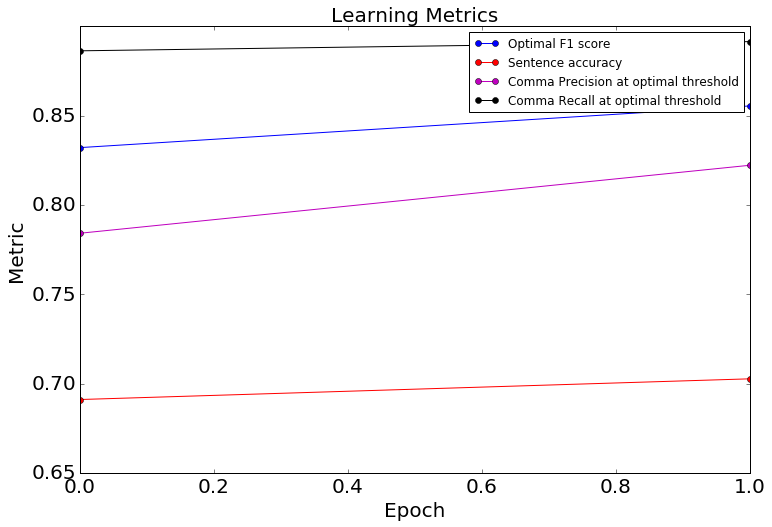

In [45]:
metrics.plot_metrics(RUNS[0][2])